In [45]:
%matplotlib inline
# %matplotlib notebook

from __future__ import print_function

try:
    from importlib import reload
except:
    pass

import os
import sys
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy.constants import h
from scipy.integrate import simps

from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import astropy.units as u

In [46]:
import pyCoCo as pccsims
import pycoco as pcc

reload(pcc)
reload(pcc.defaults)
reload(pcc.kcorr)
reload(pcc.classes)
reload(pccsims)

<module 'pyCoCo' from '/Users/berto/Code/CoCo/pyCoCo.cpython-36m-darwin.so'>

## Atmosphere
---
Load in the Atmosphere

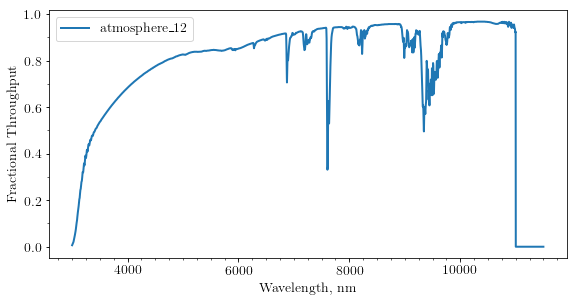

In [6]:
# atmos = pcc.kcorr.load_atmosphere()
path = os.path.join(pcc._default_lsst_throughputs_path, "baseline/atmos_std.dat")
atmos = pcc.BaseFilterClass()
atmos.load(path, wavelength_u = u.nm, fmt = "ascii.commented_header", name = "atmosphere_12")
atmos.plot()

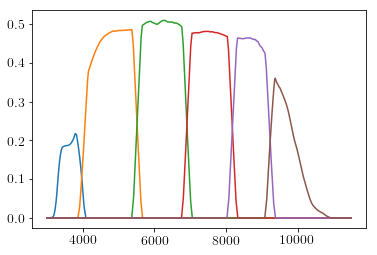

In [43]:
lsst_hardware_filters = ["hardware_u", "hardware_g", "hardware_r", "hardware_i", "hardware_z", "hardware_y"]

fdict = {}

for filter_name in lsst_hardware_filters:
    filter_path = os.path.join(pcc._default_filter_dir_path, filter_name + ".dat")
#     filter_path = os.path.join("/Users/berto/projects/LSST/throughputs/baseline/", filter_name + ".dat")
#     fdict[filter_name] = pcc.load_filter(filter_path)    
    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path)
    fdict[filter_name].filter_name = filter_name
#     pcc.load_filter(filter_path)    

fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_hardware_filters:
    plt.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"])
plt.show()

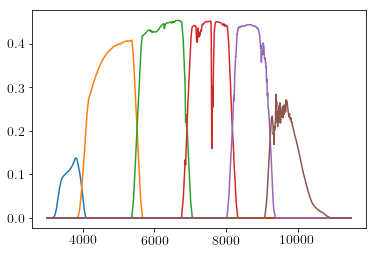

In [7]:
lsst_filters = ["LSST_u", "LSST_g", "LSST_r", "LSST_i", "LSST_z", "LSST_y"]

fdict = {}

for filter_name in lsst_filters:
    filter_path = os.path.join(pcc._default_filter_dir_path, filter_name + ".dat")
#     filter_path = os.path.join("/Users/berto/projects/LSST/throughputs/baseline/", filter_name + ".dat")
#     fdict[filter_name] = pcc.load_filter(filter_path)    
    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path)
    fdict[filter_name].filter_name = filter_name
#     pcc.load_filter(filter_path)    

fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_filters:
    plt.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"])
plt.show()

## Zeropoints
---

We have loaded in the throughputs.

3.93779818469e-09 1.86328935966e-08


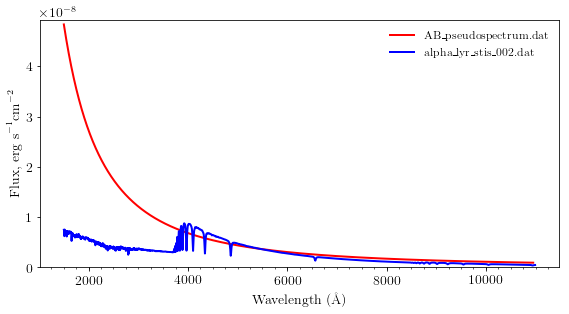

In [11]:
AB = pcc.kcorr.load_AB(wmin = 1500*u.angstrom)
vega = pcc.kcorr.load_vega(wmin = 1500*u.angstrom)
# AB.plot()

pcc.compare_spec(AB, vega)

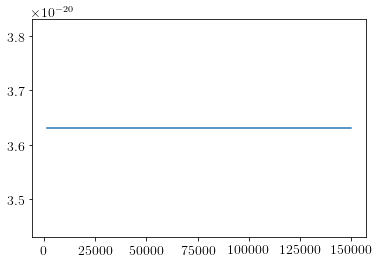

In [12]:
reload(pcc.kcorr)
gen_AB = pcc.kcorr.generate_AB_pseudospectrum(fnu = True)
fnuAB = pcc.SpectrumClass()
plt.plot(pcc.kcorr.nu_to_lambda(gen_AB["frequency"]), gen_AB["flux"])

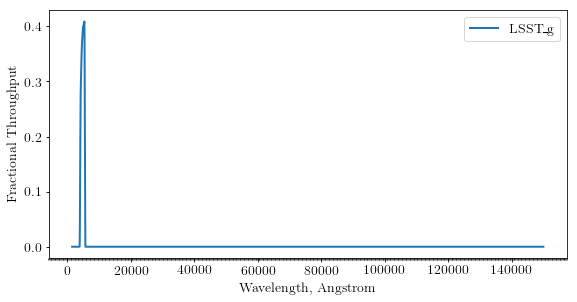

In [13]:
g = fdict["LSST_g"]
g.resample_response(new_wavelength = pcc.kcorr.nu_to_lambda(gen_AB["frequency"]))
g.plot()

In [14]:
filter_area = simps(g.throughput, g.wavelength)
transmitted_spec = g.throughput * gen_AB["flux"]
integrated_flux = simps(transmitted_spec, g.wavelength)
filter_flux = integrated_flux/filter_area

# print(filter_area)
print(filter_flux)
print(-2.5*np.log10(filter_flux))

3.63078e-20
48.6000001638


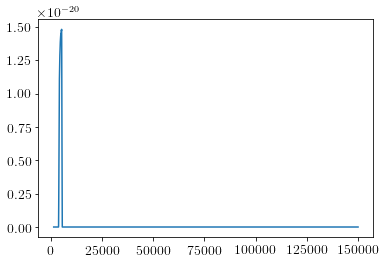

In [15]:
plt.plot(g.wavelength, transmitted_spec)

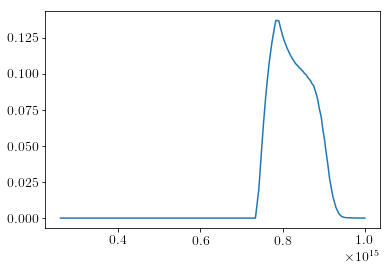

In [16]:
plt.plot(pcc.kcorr.lambda_to_nu(fdict["LSST_u"].data["wavelength"]), fdict["LSST_u"].data["throughput"])

In [17]:
2.5*np.log10(pcc.calc_spectrum_filter_flux("LSST_g", AB))

-20.800353097326671

In [18]:
2.5*np.log10(pcc.calc_spectrum_filter_flux("LSST_g", vega))

-20.702138732570411

In [ ]:
# For counts:
eff_Diameter = 6.423*u.m
eff_Area = np.pi*(0.5*eff_Diameter)**2 ## in metres
print(eff_Area)
eff_Area = np.pi*(0.5*eff_Diameter.to(u.cm))**2
print(eff_Area)
eff_Area_cm = eff_Area.to(u.cm*u.cm).value
print(eff_Area_cm)

In [ ]:
h

In [ ]:
-2.5*np.log10((30*eff_Area_cm/h.value)*pcc.calc_spectrum_filter_flux("LSST_u", AB))

## Sky Brightness
---
Load in the sky spectrum

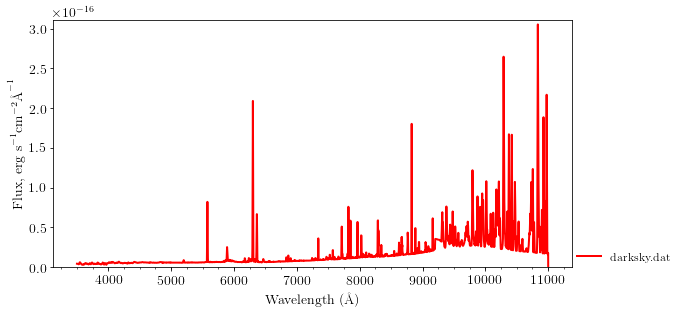

In [39]:
reload(pcc)
reload(pcc.kcorr)
reload(pcc.classes)

dark_sky_path = os.path.join(os.environ["LSST_THROUGHPUTS_BASELINE"],"darksky.dat")
darksky = pcc.SpectrumClass()
darksky.load(dark_sky_path, wavelength_u = u.nm, flux_u = u.cgs.erg / u.si.cm ** 2 / u.si.s / u.nm,
             fmt = "ascii.commented_header", wmin = 3500*u.angstrom, wmax = 11000*u.angstrom,)
darksky.plot()

Which is equivalent to:

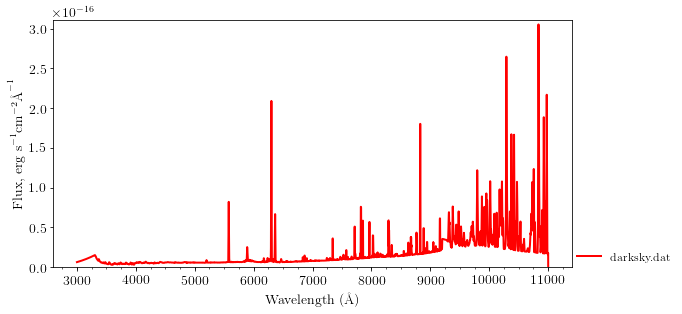

In [40]:
darksky = pcc.kcorr.load_dark_sky_spectrum()
darksky.plot()

From - http://smtn-002.lsst.io/en/latest/#sky-counts
>When calculating sky background counts per pixel, instead of using the entire hardware system plus atmosphere, the Fν(λ)Fν(λ) value for the sky spectrum should be multiplied by only the hardware.[1] The skybrightness in magnitudes per sq arcsecond then is used to calculate counts per sq arcsecond, and converted to counts per pixel using the pixelScale, 0.2”/pixel.

In [44]:
for filter_name in lsst_hardware_filters:
    zp = pcc.kcorr.calc_AB_zp(filter_name)
    print(filter_name, " F_sky = ", pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky))
    print(filter_name, "zp = ",zp)        
    print(filter_name, "m_sky = ", -2.5 * np.log10(pcc.kcorr.calc_spectrum_filter_flux(filter_name, darksky)) - zp)    

/Users/berto/Code/verbose-enigma/pycoco/classes.py:1955: UserWarning: No self.lambda_effective set.
  if hasattr(self, 'lambda_effective'):


hardware_u  F_sky =  5.49181090089e-18
hardware_u zp =  20.206744664
hardware_u m_sky =  22.943966399
hardware_g  F_sky =  6.00160221655e-18
hardware_g zp =  20.7895133655
hardware_g m_sky =  22.2648186165
hardware_r  F_sky =  9.39147796094e-18
hardware_r zp =  21.3605594086
hardware_r m_sky =  21.2076057322
hardware_i  F_sky =  1.22527533106e-17
hardware_i zp =  21.7873801803
hardware_i m_sky =  20.4920355953
hardware_z  F_sky =  2.0711859202e-17
hardware_z zp =  22.1023062502
hardware_z m_sky =  19.607146037
hardware_y  F_sky =  4.0843315018e-17
hardware_y zp =  22.3316228548
hardware_y m_sky =  18.6405746851


In [ ]:
lsst_hardware_filters = ["hardware_u", "hardware_g", "hardware_r", "hardware_i", "hardware_z", "hardware_y"]
fdict = {}

for filter_name in lsst_hardware_filters:
    filter_path = os.path.join("/Users/berto/projects/LSST/throughputs/baseline/", filter_name + ".dat")

    fdict[filter_name] = pcc.FilterClass()
    fdict[filter_name].load(filter_path, wavelength_u = u.nm)  
    fdict[filter_name].filter_name = filter_name

fig = plt.figure()

ax1 = fig.add_subplot(111)

for filter_name in lsst_hardware_filters:
    plt.plot(fdict[filter_name].data["wavelength"], fdict[filter_name].data["throughput"])
plt.show()